In [1]:

import os
#os.environ["XLA_FLAGS"] = (
#    "--xla_gpu_strict_conv_algorithm_picker=false "
#    "--xla_gpu_enable_cudnn_frontend=false "
#    "--xla_gpu_autotune_level=0"
#)
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
os.environ["JAX_PLATFORMS"] = "cuda"  # or: os.environ["JAX_PLATFORM_NAME"]="cuda"
#using GPU, comment out if on CPU?
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import jax
jax.config.update("jax_disable_jit", False)

jax.config.update("jax_debug_nans", True)
print(jax.lib.xla_bridge.get_backend().platform_version)  # sanity: shows CUDA/cuDNN


PJRT C API
cuda 12030


/tmp/ipykernel_925663/2709273283.py:17: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  print(jax.lib.xla_bridge.get_backend().platform_version)  # sanity: shows CUDA/cuDNN


In [2]:
import diffhydro as dh
from diffhydro.utils.io import athinput,athdf


In [3]:
eq = dh.equationmanager.EquationManager()


In [4]:
#manually map from athena file to my format
import jax.numpy as jnp
sol = jnp.zeros((5,128,256))
#sol = sol.at[0].set(0.01)
#sol = sol.at[1].set(0)
#sol = sol.at[2].set(0)
#sol = sol.at[3].set(0)
#sol = sol.at[4].set(0.01)
#sol = sol.at[4,64,64].set(1000)
athena_outputs_loc = "/gpfs02/work/bhorowitz/amr2/rf_kh_amrv2.out2.00010.athdf"

evolved = athdf(athena_outputs_loc)


ICs = eq.get_conservatives_from_primitives(jnp.stack([evolved["rho"][0],evolved["vel2"][0],evolved["vel1"][0],evolved["vel3"][0],evolved["press"][0]]))

2025-10-14 20:57:09.112227: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.6 which is older than the PTX compiler version 12.9.86. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [5]:
from scipy import ndimage

#get it at the correct resolution
def ds(field):
    return ndimage.zoom(field,1/2)

for i in range(0,5):
    sol = sol.at[i].set(ds(ICs[i]))


In [6]:
import flax
import jax

In [7]:
jax.__version__,flax.__version__

('0.4.33', '0.12.0')

In [8]:
import jax.numpy as jnp
from flax import linen as nn
import jax

In [58]:
import jax.numpy as jnp
from flax import linen as nn
import jax

import jax
import jax.numpy as jnp
from flax import linen as nn
from jax import lax

#kinda annoying work around for some CUDA incompatabilities...

def _kernel_fft_hwio_to_hwco_fft(k, H, W):
    """k: [kh, kw, Cin, Cout] -> Kf: [H, W//2+1, Cin, Cout] in rfft2 domain."""
    kh, kw, Cin, Cout = k.shape
    # Place kernel at the top-left corner in an HxW canvas
    kp = jnp.zeros((H, W, Cin, Cout), dtype=k.dtype)
    kp = kp.at[:kh, :kw, :, :].set(k)
    # Center the kernel so that its center acts as the conv origin (periodic SAME)
    kp = jnp.roll(kp, shift=-(kh//2), axis=0)
    kp = jnp.roll(kp, shift=-(kw//2), axis=1)
    # FFT over spatial dims; rfft2 because inputs are real
    Kf = jnp.fft.rfft2(kp, s=(H, W), axes=(0, 1))
    return Kf  # [H, W//2+1, Cin, Cout] complex64/128

def conv2d_fft_periodic(x, k):
    """
    x: [N, H, W, Cin] real
    k: [kh, kw, Cin, Cout] real (HWIO)
    returns y: [N, H, W, Cout] real (periodic 'SAME' conv)
    """
    N, H, W, Cin = x.shape
    kh, kw, Cin2, Cout = k.shape
    assert Cin == Cin2, "Cin mismatch"

    # FFT of input
    Xf = jnp.fft.rfft2(x, s=(H, W), axes=(1, 2))               # [N, H, W//2+1, Cin]
    Kf = _kernel_fft_hwio_to_hwco_fft(k, H, W)                  # [H, W//2+1, Cin, Cout]

    # Multiply in frequency domain and sum over Cin
    # out_f[n,h,wf,cout] = sum_cin Xf[n,h,wf,cin] * Kf[h,wf,cin,cout]
    Yf = jnp.einsum('nhwc,hwco->nhwo', Xf, Kf)

    # Inverse FFT back to real space
    y = jnp.fft.irfft2(Yf, s=(H, W), axes=(1, 2)).real          # [N,H,W,Cout]
    return y

class ConvFFTPeriodic(nn.Module):
    features: int
    kernel_size: tuple[int, int]
    use_bias: bool = True
    param_dtype: any = jnp.float32

    @nn.compact
    def __call__(self, x):
        kh, kw = self.kernel_size
        Cin = x.shape[-1]
        k = self.param("kernel", nn.initializers.lecun_normal(),
                       (kh, kw, Cin, self.features), self.param_dtype)
        y = conv2d_fft_periodic(x, k)
        if self.use_bias:
            b = self.param("bias", nn.initializers.zeros, (self.features,), self.param_dtype)
            y = y + b
        return y


class CNN(nn.Module):
  """A simple CNN model."""
  @nn.compact
  def __call__(self, x):
    #very random network... no real optimization
    x = ConvFFTPeriodic(features=12, kernel_size=(3,3))(x)
    y = nn.selu(x)
    y = ConvFFTPeriodic(features=24, kernel_size=(5, 5))(y)
    y = nn.tanh(y)
    y = ConvFFTPeriodic(features=32, kernel_size=(5, 5))(y)
    y = nn.selu(y)
    y = jnp.append(x,y,axis=-1)
    y = ConvFFTPeriodic(features=32, kernel_size=(3, 3))(y)
    x = nn.selu(y)
    x = ConvFFTPeriodic(features=16, kernel_size=(3, 3))(x)
    x = nn.selu(x)
    x = ConvFFTPeriodic(features=5, kernel_size=(3, 3))(x)
    return x

model = CNN()

#specify input shape
x = jnp.ones((1, 128, 256 ,5))  # [batch, D, H, channels]

params = model.init(jax.random.PRNGKey(0), x)
mask = jnp.array([[1,1,1,0,1],[1,1,1,0,1]])*1E-4 #zero out z direction? probably could reshape for more efficiency

    

In [59]:
example = model.apply(params,x)

In [60]:
(example*jnp.array([[1,1,1,0,1],[1,1,1,0,1]])[0]).shape

(1, 128, 256, 5)

In [61]:
jnp.swapaxes((example*jnp.array([[1,1,1,0,1],[1,1,1,0,1]])[0]),0,-1).shape

(5, 128, 256, 1)

In [62]:
class CorrectionFlux:
    def __init__(self,
                 model,mask,dt):
        self.model = model
        self.dt = dt
        self.mask = mask
        
    def timestep(self,sol):
        return self.dt
        
    def flux(self,sol,ax,params,flux):
      #  print(sol.shape,flux.shape)
        fields = sol #jnp.vstack([sol])
      #  print(fields.shape)
        in_field = jnp.rollaxis(fields[:,:,:],0,3).reshape(1,128,256,5)
       # print("input shape",in_field.shape)
        y = self.model.apply(params, in_field)
       # print("outshape",y.shape)
        #mask unused axis
        y = jnp.swapaxes((y*jnp.array(self.mask)[ax]),0,-1)[:,:,:,0]
      #  print("outshape",y.shape)
        return y

In [72]:
correction = CorrectionFlux(model,mask*1E2,10000)

In [73]:
eq = dh.equationmanager.EquationManager()
#eq.box_size = (128.0, 256.0,1.0)
ss = dh.signal_speed_Rusanov
solver = dh.HLLC(equation_manager=eq,signal_speed=ss)
cf = dh.ConvectiveFlux(eq,solver,dh.MUSCL3(limiter="VANLEER"))
hydrosim = dh.hydro(n_super_step=770,fluxes=[cf,correction],splitting_schemes=[[2,1,1,2],[1,2,2,1],],maxjit=True)

In [74]:
q = hydrosim.evolve(sol,params)

dt [Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>, 10000, 10000000000.0]


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


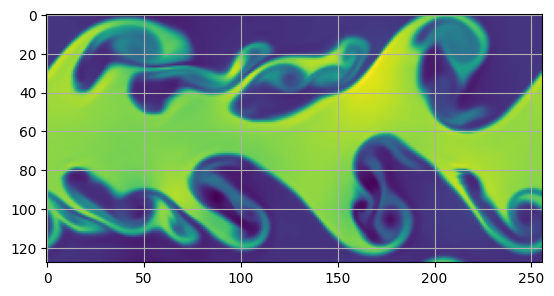

In [75]:
%pylab inline
imshow(q[0][0])
grid()

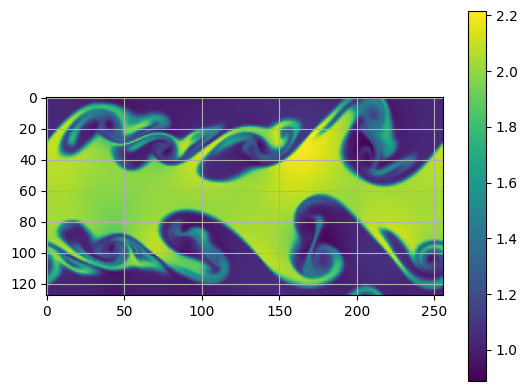

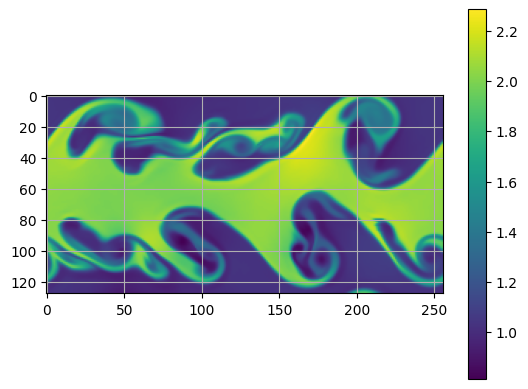

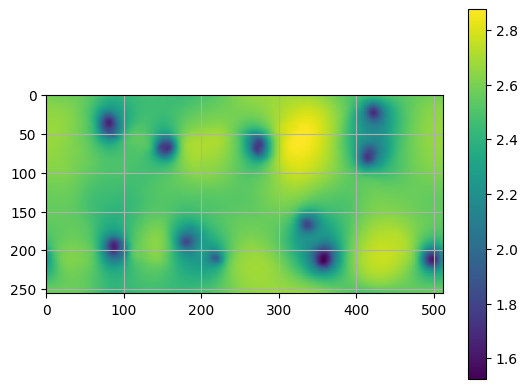

In [76]:
athena_outputs_loc = "/gpfs02/work/bhorowitz/amr2/rf_kh_amrv2.out2.00025.athdf"

evolved = athdf(athena_outputs_loc)

imshow(ndimage.zoom(evolved["rho"][0],0.5))
grid()
colorbar()
show()
imshow(q[0][0])
grid()
colorbar()
show()

imshow(evolved["press"][0])
grid()
colorbar()

In [77]:
print(nn.tabulate(
    model, jax.random.key(0))(x))


                                  CNN Summary                                   
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ path          ┃ module        ┃ inputs        ┃ outputs       ┃ params       ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│               │ CNN           │ float32[1,12… │ float32[1,12… │              │
├───────────────┼───────────────┼───────────────┼───────────────┼──────────────┤
│ ConvFFTPerio… │ ConvFFTPerio… │ float32[1,12… │ float32[1,12… │ bias:        │
│               │               │               │               │ float32[12]  │
│               │               │               │               │ kernel:      │
│               │               │               │               │ float32[3,3… │
│               │               │               │               │              │
│               │               │               │               │ 552 (2.2 KB) │
├───────────────┼──────────

In [78]:
q[0].shape

(5, 128, 256)

In [79]:
from scipy import ndimage
data_rho = ndimage.zoom(evolved["rho"][0],1/2)
data_press = ndimage.zoom(evolved["press"][0],1/2)

@jax.jit
def likelihood(params):
    fields = jnp.vstack([q[0],q[0]])
    in_field = jnp.rollaxis(fields[:,:,:],0,3).reshape(1,128,256,10)

    out2 = model.apply(params,in_field)#hydrosim.evolve(sol,params)
    print(out2.shape)
    out2 = jnp.swapaxes((out2),0,-1)[:,:,:,0]
    print(out2.shape)

    primatives_from_sim = eq.get_primitives_from_conservatives(out2)
    return jnp.sum((primatives_from_sim[0]-data_rho)**2) + jnp.sum((primatives_from_sim[-1]-data_press)**2) 

In [80]:
@jax.jit
def likelihood(params):
    fields = jnp.vstack([q[0],q[0]])
    in_field = jnp.rollaxis(fields[:,:,:],0,3).reshape(1,128,256,10)

    out2 = hydrosim.evolve(sol,params)

    print(out2[0].shape)
    primatives_from_sim = eq.get_primitives_from_conservatives(out2[0])
    return jnp.sum((primatives_from_sim[0]-data_rho)**2) + jnp.sum((primatives_from_sim[-1]-data_press)**2) 

In [81]:
likelihood(params)

(5, 128, 256)


Array(1895.32, dtype=float32)

In [82]:
vag = jax.value_and_grad(likelihood)

In [83]:
outvag = vag(params)

In [84]:
#outvag[1]['params']['ConvFFTPeriodic_0']['kernel']

In [87]:
import time
bl = 1E5
variables=params

In [ ]:

learning_rate = 1E-7# Gradient step size.

@jax.jit
def update_params(params, learning_rate, grads):
  params = jax.tree_util.tree_map(
      lambda p, g: p - learning_rate * g, params, grads)
  return params

loss_array = []
st = time.time()
for i in range(100):
  print(i,time.time()-st, learning_rate)
  # Perform one gradient update.
  loss_val, grads = vag(variables)
  print(f'Loss step {i}: ', loss_val)
  loss_array.append(loss_val)
  if loss_val < bl:
    print("new best value")
    bv = variables
    bl = loss_val
    learning_rate *=1.05
  else:
    learning_rate *=0.85
  variables = update_params(variables, learning_rate, grads)


0 0.00015544891357421875 1e-07


In [93]:
print(bl)

676.72906


In [1]:
print(bl)

NameError: name 'bl' is not defined

In [101]:
import pickle
with open('model_params.pkl', 'wb') as f:
    pickle.dump(bv, f)

In [102]:
q = hydrosim.evolve(sol,params)

In [104]:
hydrosim_fid = dh.hydro(n_super_step=770,fluxes=[cf],splitting_schemes=[[2,1,1,2],[1,2,2,1],],maxjit=True)
q_fid = hydrosim_fid.evolve(sol,{})

dt [Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>, 10000000000.0]


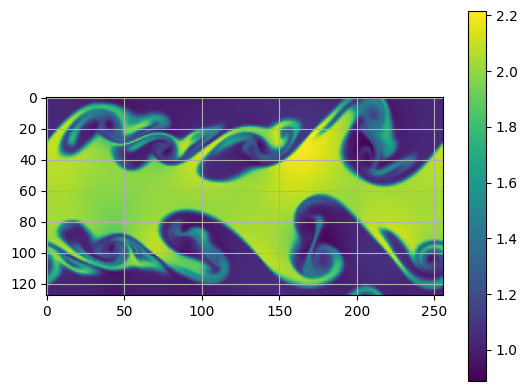

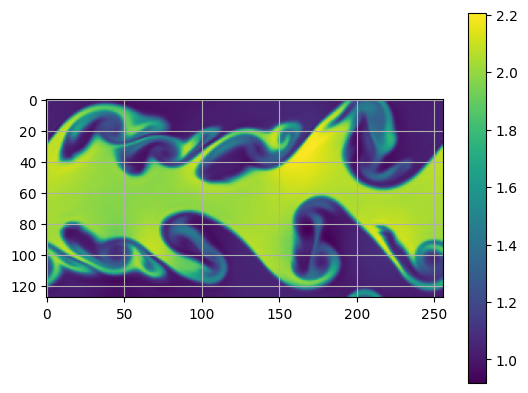

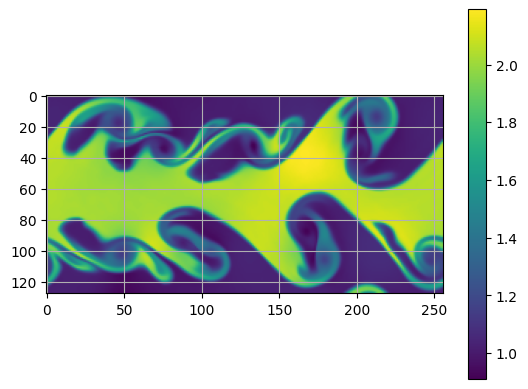

In [105]:
imshow(ndimage.zoom(evolved["rho"][0],0.5))
grid()
colorbar()
show()

imshow(q[0][0])
grid()
colorbar()
show()


imshow(q_fid[0][0])
grid()
colorbar()
show()